In [112]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.arima_model import ARIMA
import timeit
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from fbprophet import Prophet

## Dataprep

In [113]:
ts = pd.read_csv('./data/dataframe_yearly.csv', index_col=0, usecols=[0,2])

In [114]:
ts.head()

,ice_extent
Year,
1979,12.349634
1980,12.349545
1981,12.147230
1982,12.467336
1983,12.353095


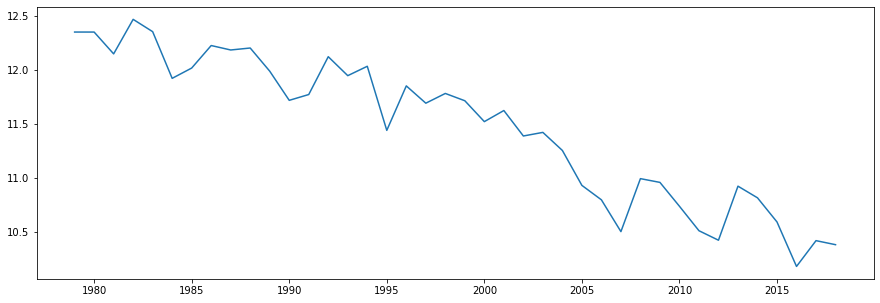

In [115]:
plt.plot(ts)

### Differentiatie

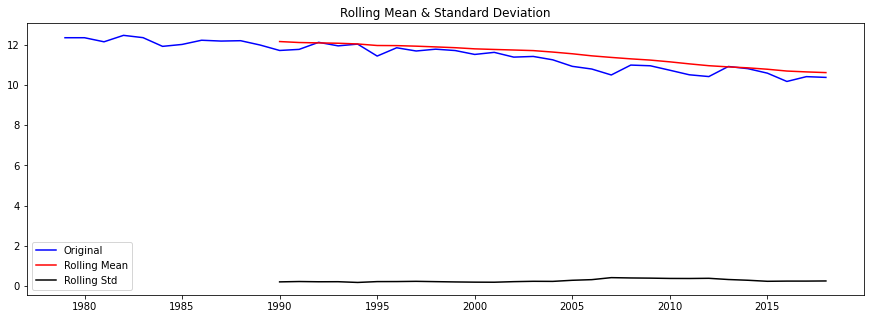

In [116]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(ts)

Duidelijk dalende trend dus passen we differentiatie toe

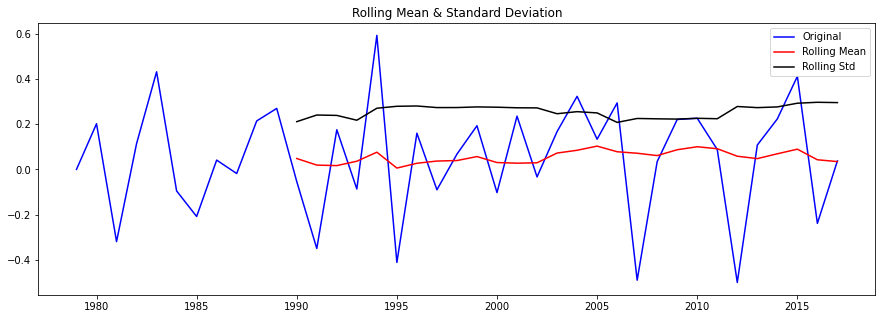

In [117]:
ts_diff = ts - ts.shift(-1)
ts_diff = ts_diff.dropna()
test_stationarity(ts_diff)

Deze data is stationair dus kunnen we modellen beginnen opbouwen

### Cross validation setup

In [120]:
tscv = TimeSeriesSplit(n_splits = 8)

for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 23
TEST: 4

TRAIN: 27
TEST: 4

TRAIN: 31
TEST: 4

TRAIN: 35
TEST: 4



### General methods

In [121]:
def full_graph(predicted_diff, title):
    predictionsArray = np.asarray(revert_diff(predicted_diff, ts))
    zerosArray = np.zeros(ts.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    
    # plot
    plt.title(title)
    plt.plot(ts.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 3 year prediction')
    plt.ylim([0,15])
    plt.legend()

    plt.show()
    
def revert_diff(predicted_diff, og_data):
    last_value = og_data.iloc[-predicted_diff.size+1][0]
    predicted_actual = np.array([])
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
    return predicted_actual

### ARIMA

In [123]:
%%time
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 10)
d = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
best_pdq = pdq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(ts_diff):
            if train_index.size > 20:
                # initialize cross validation train and test sets
                cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

                # build model
                model = ARIMA(cv_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
                prediction_values = predictions.values
                true_values = cv_test.values
                # error calc
                #     print(true_values)
                #     print(predictions.values)
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pdq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pdq)

# best range(0,10): 
# Best MAE = 0.1707774966080089
# (3, 0, 0)
# Wall time: 9min 2s

(0, 0, 0)
MAE: 0.20032300742771306
(0, 0, 1)
MAE: 0.20740129943526048
(0, 0, 2)
Input contains NaN, infinity or a value too large for dtype('float64').
(0, 0, 3)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 5)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 7)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params

MAE: 0.20619543660035894
(2, 0, 1)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 0, 2)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 0, 3)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 0, 4)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 0, 5)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(2, 0, 6)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model o

MAE: 0.17381488830773667
(4, 0, 1)
MAE: 0.17094700569236204
(4, 0, 2)
SVD did not converge
(4, 0, 3)
MAE: 0.19260727635253366
(4, 0, 4)
SVD did not converge
(4, 0, 5)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(4, 0, 6)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(4, 0, 7)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(4, 0, 8)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(4, 0, 9)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_para

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(6, 0, 0)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(6, 0, 1)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(6, 0, 2)
MAE: 0.18421011359431955
(6, 0, 3)
MAE: 0.21553724646758665
(6, 0, 4)
SVD did not converge
(6, 0, 5)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(6, 0, 6)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(6, 0, 7)
The computed initial AR coefficients are not stationa

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(7, 2, 8)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(7, 2, 9)
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(8, 0, 0)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(8, 0, 1)
MAE: 0.24066798580239537
(8, 0, 2)
SVD did not converge
(8, 0, 3)
SVD did not converge
(8, 0, 4)
SVD did not converge
(8, 0, 5)
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(8, 0, 6)
The computed initial AR c

SVD did not converge

Best MAE = 0.1707774966080089
(3, 0, 0)
Wall time: 9min 2s


In [ ]:
# best_pdq = (3, 0, 0)

----
IIII
Mean MAE: 0.171 x 1 000 000 km²
MAE of last prediction: 0.103 x 1 000 000 km²
Execution time: 0.449 seconds


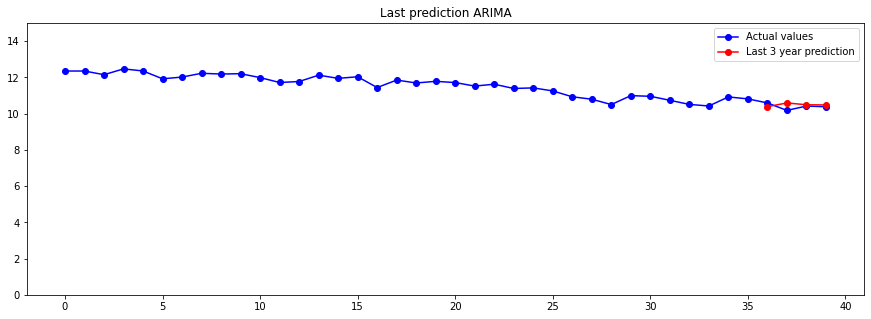

In [127]:
start_time = timeit.default_timer()


warnings.filterwarnings("ignore") # specify to ignore warning messages

print("----")

maes = []

for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        # build model
        arima = ARIMA(cv_train, best_pdq).fit(start_ar_lags=1,disp=False)

        # make predictions
        predictions = arima.forecast(steps=4)
        prediction_values = predictions[0]
        true_values = cv_test.values

        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        # last actual prediction 
        last_prediction_ARIMA = prediction_values

        print("I",end="")

time_ARIMA = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_ARIMA = mae_mean
last_MAE_ARIMA = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_ARIMA)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_ARIMA)
print('Execution time: %.3f seconds' % time_ARIMA)
full_graph(last_prediction_ARIMA, 'Last prediction ARIMA')

### LSTM

In [11]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
def build_model(raw_seq, n_steps_in, n_steps_out, n_features):
    # split into samples
    X, y = split_sequence(raw_seq.values.flatten(), n_steps_in, n_steps_out)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    
    # fit model
    model.fit(X, y, epochs=50, verbose=0)
    
    return model


def predict(x_input, model, n_features):
    n_features = 1
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

----------
IIIIIIIIII
Mean MAE: 0.183 x 1 000 000 km²
MAE of last prediction: 0.215 x 1 000 000 km²
Execution time: 24.999 seconds


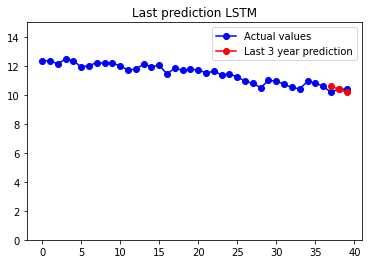

Wall time: 25.1 s


In [12]:
%%time

start_time = timeit.default_timer()

# Disabled tf warning because of visual clutter
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# variables
n_steps_in = 3
n_steps_out = 3
n_features  = 1
maes = []

print("----------")

for train_index, test_index in tscv.split(ts_moving_avg_diff):
    
    # initialize cross validation train and test sets
    y_train, y_test = ts_moving_avg_diff.iloc[train_index], ts_moving_avg_diff.iloc[test_index]

    # build model
    lstm_model = build_model(y_train, n_steps_in, n_steps_out, n_features)

    # make predictions
    x_input = array(y_test)
    y_predicted = predict(x_input, lstm_model, n_features).flatten()
    y_actual = y_test.values
    
    # error calc
    maes.append(mean_absolute_error(y_actual, y_predicted))
    
    print("I",end="")

# last actual prediction 
last_prediction_LSTM = y_predicted + moving_avg.dropna().iloc[test_index].values.flatten()
 
time_LSTM = timeit.default_timer() - start_time
MAE_LSTM = np.mean(maes)
last_MAE_LSTM = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_LSTM)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_LSTM)
print('Execution time: %.3f seconds' % time_LSTM)
full_graph(last_prediction_LSTM, 'Last prediction LSTM')

### Prophet

----------


INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


III
Mean MAE: 0.164 x 1 000 000 km²
MAE of last prediction: 0.149 x 1 000 000 km²
Execution time: 43.794 seconds


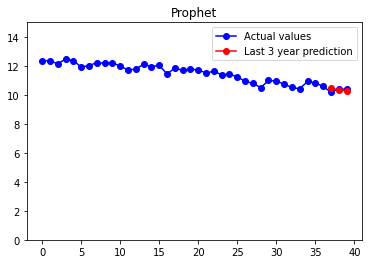

In [13]:
# Disabled tf warning because of clutter
warnings.filterwarnings("ignore") # specify to ignore warning messages

maes = []

# formatting dataframe
ts_formated_prophet = ts_moving_avg_diff.reset_index().rename(columns = {'Year' : 'ds', 'ice_extent' : 'y'})
ts_formated_prophet['ds'] = pd.DataFrame(pd.to_datetime(ts_formated_prophet['ds'].astype(str), format='%Y'))

print("----------")

for train_index, test_index in tscv.split(ts_formated_prophet):

    # initialize cross validation train and test sets
    train  = ts_formated_prophet.iloc[train_index]
    y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
    X_test = ts_formated_prophet.iloc[test_index][['ds']]
        
    # build model
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(train)

    # make predictions
    forecast = model.predict(X_test)
    y_pred = forecast['yhat'].values
    
    # error calc
    maes.append(mean_absolute_error(y_test, y_pred))
    
    # last actual prediction 
    last_prediction_prophet = y_pred + moving_avg.dropna().iloc[test_index].values.flatten()

    print("I",end="")

time_Prophet = timeit.default_timer() - start_time
MAE_Prophet = np.mean(maes)
last_MAE_Prophet = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_Prophet)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_Prophet)
print('Execution time: %.3f seconds' % time_Prophet)
full_graph(last_prediction_prophet, "Prophet")

### Evaluation

In [14]:
results = [[MAE_ARIMA,time_ARIMA,last_MAE_ARIMA],[MAE_LSTM,time_LSTM,last_MAE_LSTM],[MAE_Prophet,time_Prophet,last_MAE_Prophet]]
pd.DataFrame(results, columns=['Mean MAE (x 1 000 000 km\u00b2)','Execution time (s)','Last MAE (x 1 000 000 km\u00b2)'],index=['ARIMA','LSTM','Prophet']).round(decimals=3)


,Mean MAE (x 1 000 000 km²),Execution time (s),Last MAE (x 1 000 000 km²)
ARIMA,0.119,0.802,0.066
LSTM,0.183,24.999,0.215
Prophet,0.164,43.794,0.149


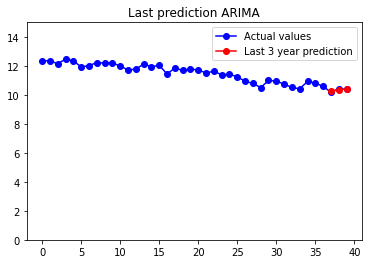

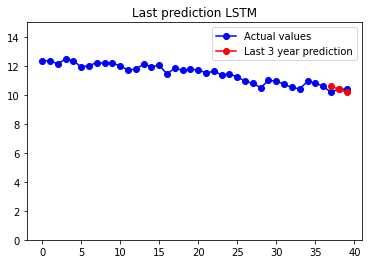

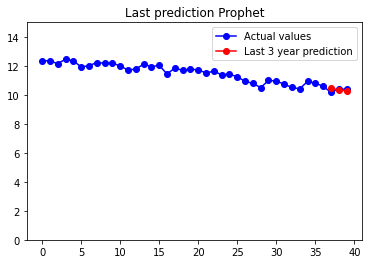

In [15]:
full_graph(last_prediction_ARIMA, "Last prediction ARIMA")
full_graph(last_prediction_LSTM, "Last prediction LSTM")
full_graph(last_prediction_prophet, "Last prediction Prophet")